In [56]:
from collections import Counter
import os
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import pprint

In [57]:
# Read RoO data
roo_texts = {}
roo_folder = 'RoO Non-table/roo_clean_2'

# roo_clean_2 -> UTF-8 ('cause Ms. Word?), roo_clean -> ANSI
for filename in os.listdir(roo_folder):
    with open(roo_folder + '/' + filename, mode='r', encoding='utf-8') as f:
        # Replace en dash with hyphen
        roo_texts[filename[:-4]] = f.read().replace('–', '-')

In [58]:
# Check how many sections within the RoO
# Apparently India is missing some sections: X, XIV, XIX, XXI
pattern_count = re.compile('Section [IVX]{1,5}')
for fta, rule in roo_texts.items():
    print(fta, len(pattern_count.findall(rule)))

# Clean some misconverted HS code
# Update apparently there are no misconverted hs code with new file!
def addZero(matchobj):
    """Example: Instead of 21.6, which is a wrong HS code, return 21.06"""
    hs_code = matchobj[0]
    return hs_code[:-1] + '0' + hs_code[-1]

#pattern_zero = re.compile(r'\b\d{1,2}\.\d\b')
#for fta, rule in roo_texts.items():
#    roo_texts[fta] = pattern_zero.sub(addZero, rule)

BRN_JPN 21
CHL_JPN 21
IDN_JPN 21
IND_JPN 17
JPN_MEX 21
JPN_MYS 21
JPN_PER 21
JPN_PHL 21
JPN_THA 21


In [59]:
# Read csv files of different versions of HS code mapping
HS_maps = {
    2002: pd.read_csv('HS2.csv'),
    2007: pd.read_csv('HS3.csv'),
    2012: pd.read_csv('HS4.csv'),
    2017: pd.read_csv('HS5.csv')
}

# Read the HS code version used in each agreement
HS_map_used = {}
for row in pd.read_csv('HS_ver.csv').itertuples(index=None, name=None):
    HS_map_used[row[0]] = HS_maps[row[1]]

In [60]:
# FUNCTION FOR EXTRACTING HS CODES
def get_hs_codes(hs_code1, hs_code2, HS_map):
    """Given a range of HS codes, return list of all HS codes within."""
    # Clean HS codes
    hs_code1 = hs_code1.replace('.', '')
    hs_code2 = hs_code2.replace('.', '')
    
    if not hs_code2:
        result = HS_map.loc[(HS_map['ProductCode'].str.startswith(hs_code1)) & (HS_map['Tier'] == 3)]
        return list(result['ProductCode'])
        
    try:
        # Is there a way to index by value? HS_map['ProductCode'].indval(hs_code) ?
        index_1 = HS_map.loc[HS_map['ProductCode'] == hs_code1].index[0]
        index_2 = HS_map.loc[HS_map['ProductCode'] == hs_code2].index[0]

        range_1 = HS_map.loc[HS_map['Tier'] == 3].loc[index_1:index_2]
        range_2 = HS_map.loc[(HS_map['ProductCode'].str.startswith(hs_code2)) & (HS_map['ProductCode'] != hs_code2)
                             & (HS_map['Tier'] == 3)]

        result = pd.concat([range_1, range_2], ignore_index=True)
        return list(result['ProductCode'])

    except:
        print(hs_code1, hs_code2)

print(get_hs_codes('39.06', '39.07', HS_maps[2002]))

['390610', '390690', '390710', '390720', '390730', '390740', '390750', '390760', '390791', '390799']


In [61]:
# CREATE A DICTIONARY FOR FASTER ACCESS TO ALL HS CODES
def expand_map(HS_map):
    """Given part of HS code (chapter, heading, or subheading), return list
    containing all 6-digit HS code within it.
    """
    expanded_map = {}
    # Expand chapters
    chapters = HS_map.loc[HS_map['Tier'] == 1]
    for row in chapters.itertuples(index=False, name=None):
        result = HS_map.loc[(HS_map['ProductCode'].str.startswith(row[1])) & (HS_map['Tier'] == 3)]
        expanded_map[row[1]] = list(result['ProductCode'])
    
    # Expand headings
    headings = HS_map.loc[HS_map['Tier'] == 2]
    for row in headings.itertuples(index=False, name=None):
        result = HS_map.loc[(HS_map['ProductCode'].str.startswith(row[1])) & (HS_map['Tier'] == 3)]
        expanded_map[row[1]] = list(result['ProductCode'])
    
    # Expand subheadings
    subheadings = HS_map.loc[HS_map['Tier'] == 3]
    for row in subheadings.itertuples(index=False, name=None):
        expanded_map[row[1]] = row[1]
    
    return expanded_map

HS_exp_maps = {
    2002: expand_map(HS_maps[2002]),
    2007: expand_map(HS_maps[2007]),
    2012: expand_map(HS_maps[2012]),
    2017: expand_map(HS_maps[2017])
}

HS_exp_map_used = {}
for row in pd.read_csv('HS_ver.csv').itertuples(index=None, name=None):
    HS_exp_map_used[row[0]] = HS_exp_maps[row[1]]

In [163]:
# Useful groups for regular expressions
HS_CODE = r'(\d+\.\d+)'
HS_CODE_NC = r'(?:\d+\.\d+)'
HS_RANGE = r'({0}(?:\-{0})?)'.format(HS_CODE)
HS_RANGE_NC = r'{0}(?:\-{0})?'.format(HS_CODE_NC)

def parse_roo(roo_text):
    """Given complete text of specific rules of origin, return a dictionary representing
    the complete structure of RoO (from sections to chapters)
    
    Argument:
        roo_text
    Return:
        
    """
    def clean_ws(match):
        """Reduce number of whitespaces into a single space."""
        return ' '

    # Capture sections
    pattern_section = re.compile(r'(Section\s+[IVX]{1,5})\s+(.+?)(?=Section\s+[IVX]{1,5}\s+[A-Z]|\Z)', flags=re.DOTALL)
    result = pattern_section.findall(roo_text)
    roo = {match[0]: match[1] for match in result}

    # Capture chapters in every section
    pattern_chapter = re.compile(r'(Chapter\s+\d{1,2})\s+(.+?)(?=Chapter\s+\d{1,2}\s+[A-Z]|\Z)', flags=re.DOTALL)
    for section, content in roo.items():
        result = pattern_chapter.findall(content)
        roo[section] = {match[0]: match[1] for match in result}

    # Capture rules in every chapter
    pattern_rule = re.compile(HS_RANGE + r'\s+([A-Z].+?\.)(?=\s+' + HS_RANGE_NC + r'|\s*\Z)', flags=re.DOTALL)
    pattern_whitespace = re.compile(r'\s+')    
    for section in roo:
        for chapter, rules in roo[section].items():
            result = pattern_rule.findall(rules)
            roo[section][chapter] = {match[0]: pattern_whitespace.sub(clean_ws, match[3]) for match in result}
    return roo

def get_roo_rules(roo, HS_map=None, complete=False):
    """Create a dictionary which only stores the rules without additional stuctures"""
    roo_rules = {}
    pattern_range = re.compile(HS_RANGE)
    for section in roo:
        for chapter in roo[section]:
            for hs_code_range, rule in roo[section][chapter].items():
                if complete:
                    result = pattern_range.findall(hs_code_range)
                    hs_codes = get_hs_codes(result[0][1], result[0][2], HS_map)
                    for hs_code in hs_codes:
                        roo_rules[hs_code] = rule
                else:
                    roo_rules[hs_code_range] = rule
    return roo_rules

In [63]:
roo_rules = {fta: {} for fta in roo_texts}
for fta, roo_text in roo_texts.items():
    roo_rules[fta] = get_roo_rules(parse_roo(roo_text), HS_map_used[fta], complete=True)
    print(fta, len(roo_rules[fta]))
    
# NOTE!!!
# JPN_PHL, 15.16 - 15.19 -> TYPO??? CHANGE TO 15.18

for ver, HS_map in HS_maps.items():
    print('HS', ver, ':', HS_map.loc[HS_map['Tier'] == 3]['ProductCode'].count())

BRN_JPN 5222
CHL_JPN 5212
IDN_JPN 5210
IND_JPN 2474
JPN_MEX 5224
JPN_MYS 5158
JPN_PER 5046
JPN_PHL 5222
JPN_THA 5214
HS 2002 : 5224
HS 2007 : 5052
HS 2012 : 5205
HS 2017 : 6276


In [64]:
#one = set(get_roo_rules(parse_roo(roo_texts['IND_JPN'], get_hs_map('IND_JPN'), complete=True)))
#two = set(get_roo_rules(parse_roo(roo_texts['JPN_PER'], get_hs_map('JPN_PER'), complete=True)))
#sorted(list(two-one))
#roo_texts['IND_JPN']

In [65]:
# NEXT PROJECT: ANALYZE GRAMMAR
patterns = {
    'CC': re.compile(r'A change to (?:heading|subheading) {0}(?: through {0})? from any other chapter.'.format(HS_CODE_NC)),
    'CTH': re.compile(r'A change to (?:heading|subheading) {0}(?: through {0})? from any other heading.'.format(HS_CODE_NC)),
    'CTSH': re.compile(r'A change to (?:heading|subheading) {0}(?: through {0})? from any other subheading.'.format(HS_CODE_NC)),
    'CTH_RVC': re.compile(r'A change to (?:heading|subheading) {0}(?: through {0})? from(?: subheading {0} or)? any other heading, provided there is a regional value content of not less than \d\d? percent.'.format(HS_CODE_NC)),
    'WO': re.compile(r'(?:Manufacture in which all the materials used are wholly obtained.|Goods of (?:heading|subheading) {0}(?: through {0})? are wholly obtained or produced entirely in a Party\,? as defined in Article \d\d?.)'.format(HS_CODE_NC)),
    'RVC': re.compile(r'(?:No required change in tariff classification to (?:heading|subheading) {0}(?: through {0})?, provided(?: that)? there is a (?:qualifying|regional) value content of not less than \d\d? per\s?cent.|A qualifying value content of not less than \d\d? percent.)'.format(HS_CODE_NC)),
    'WO_scrap': re.compile(r'No required change in tariff classification to (?:heading|subheading) {0}(?: through {0})?, provided(?: that)? the waste(?: and scrap are)?(?: is)? wholly obtained or produced entirely in (?:a Party|the Area of one or both Parties|the territory of a Country) as defined in Article \d\d?(?: of Chapter \d\d?)?.'.format(HS_CODE_NC)),
    'CTH_ECT': re.compile(r'A change to (?:heading|subheading) {0}(?: through {0})? from any heading outside that group.'.format(HS_CODE)),
    'CTSH_ECT': re.compile(r'A change to subheading {0}(?: through {0})? from any subheading outside that group.'.format(HS_CODE)),
    'Manufacture_1': re.compile(r'Manufacture from (?:yarns|fibres|fabrics|chemical materials or textile pulps), provided that necessary process stipulated in the Appendix is undertaken.'),
    'Manufacture_2': re.compile(r'Manufacture from (?:yarns|fibres|fabrics|chemical materials or textile pulps).'),

    'pattern_1': re.compile(r'A change to subheading {0} from any classification to subheading {0}, provided that there is a qualifying value content of not less than \d\d? percent.'.format(HS_CODE_NC)),
    'pattern_2': re.compile(r'All the animals of Chapter 1 shall be wholly obtained.')
}

for fta in roo_rules:
    begin = Counter()
    for hsc, rule in roo_rules[fta].items():
        res = []
        for pattern in patterns.values():
            res.append(pattern.search(rule))
        if any(res):
            #print(pattern1.search(rule))
            continue
        begin[rule[:20]] += 1
        if fta == 'JPN_THA':
            pass
            #print(rule)
    print(fta, sum(begin.values()))
    #print(begin, end='\n\n')
    

BRN_JPN 4
CHL_JPN 4
IDN_JPN 7
IND_JPN 7
JPN_MEX 57
JPN_MYS 9
JPN_PER 4
JPN_PHL 12
JPN_THA 7


In [179]:
def restriction_list(roo, fta):
    """From the roo structure, classify the rules.
    Side note: There is aliasing in _EST, but as long as restrictions is read-only, then there would be no problem.
    """
    HS_map, HS_exp_map = HS_map_used[fta], HS_exp_map_used[fta]
    restrictions = {}
    pattern_range = re.compile(HS_RANGE)
    for section in roo:
        for chapter in roo[section]:
            for hs_code_range, rule in roo[section][chapter].items():
                # Get HS codes
                result = pattern_range.findall(hs_code_range)
                hs_codes = get_hs_codes(result[0][1], result[0][2], HS_map)
                
                # Classify the rule
                if patterns['CC'].search(rule):
                    for hs_code in hs_codes:
                        restrictions[hs_code] = HS_exp_map[hs_code[:2]]
                if patterns['CTH'].search(rule):
                    for hs_code in hs_codes:
                        restrictions[hs_code] = HS_exp_map[hs_code[:4]]
                if patterns['CTSH'].search(rule):
                    for hs_code in hs_codes:
                        restrictions[hs_code] = HS_exp_map[hs_code]
                if patterns['CTH_ECT'].search(rule):
                    unique_headings = list(set([hs_code[:4] for hs_code in hs_codes]))
                    all_restrictions = []
                    for heading in unique_headings:
                        all_restrictions.extend(HS_exp_map[heading])
                    for hs_code in hs_codes:
                        restrictions[hs_code] = all_restrictions
                if patterns['CTSH_ECT'].search(rule):
                    all_restrictions = []
                    for hs_code in hs_codes:
                        all_restrictions.extend(HS_exp_map[hs_code])
                    for hs_code in hs_codes:
                        restrictions[hs_code] = all_restrictions
    return restrictions

roo_restriction_list = {}
for fta, roo_text in roo_texts.items():
    roo_restriction_list[fta] = restriction_list(parse_roo(roo_text), fta)
    print(fta, len(roo_restriction_list[fta]))

BRN_JPN 5148
CHL_JPN 5130
IDN_JPN 5194
IND_JPN 955
JPN_MEX 5140
JPN_MYS 5111
JPN_PER 4897
JPN_PHL 5098
JPN_THA 5115


In [180]:
chapter_restriction = {fta: Counter() for fta in roo_restriction_list}
for fta, restrictions in roo_restriction_list.items():
    HS_map, HS_exp_map = HS_map_used[fta], HS_exp_map_used[fta]    
    chapters = HS_map.loc[HS_map['Tier'] == 1, 'ProductCode']
    for chapter in chapters:
        for hs_code in HS_exp_map[chapter]:
            chapter_restriction[fta][chapter] += len(restrictions.get(hs_code, []))
    #print(fta)
    #pprint.pprint(chapter_restriction[fta], width=35)

heading_restriction = {fta: Counter() for fta in roo_restriction_list}
for fta, restrictions in roo_restriction_list.items():
    HS_map, HS_exp_map = HS_map_used[fta], HS_exp_map_used[fta]
    headings = HS_map.loc[HS_map['Tier'] == 2, 'ProductCode']
    for heading in headings:
        for hs_code in HS_exp_map[heading]:
            heading_restriction[fta][heading] += len(restrictions.get(hs_code, []))
    #print(fta)
    #pprint.pprint(heading_restriction[fta], width=35)

In [181]:
for key, val in chapter_restriction.items():
    print(key, len(val))

BRN_JPN 96
CHL_JPN 96
IDN_JPN 96
IND_JPN 96
JPN_MEX 96
JPN_MYS 96
JPN_PER 96
JPN_PHL 96
JPN_THA 96


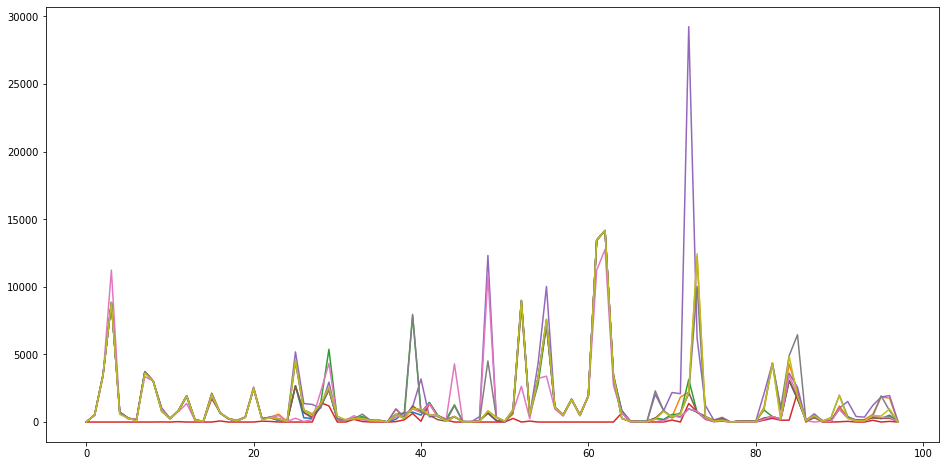

In [182]:
pool = {fta: [0 for i in range(98)] for fta in chapter_restriction}
for fta in chapter_restriction:
    for key, value in chapter_restriction[fta].items():
        pool[fta][int(key)] = value

plt.figure(figsize=(16,8))
i = 0
for fta in pool:
    #break
    if i > 9:
        break
    plt.plot(range(0, 98), pool[fta])
    i += 1
    
#plt.plot(range(0, 98), pool['BRN_JPN'])
#plt.plot(range(0, 98), pool['CHL_JPN'])
#plt.plot(range(0, 98), pool['IDN_JPN'])
#plt.plot(range(0, 98), pool['IND_JPN'])
#plt.plot(range(0, 98), pool['JPN_MEX'])
#plt.plot(range(0, 98), pool['JPN_MYS'])
#plt.plot(range(0, 98), pool['JPN_PER'])
#plt.plot(range(0, 98), pool['JPN_PHL'])
#plt.plot(range(0, 98), pool['JPN_THA'])

In [ ]:
"""
pprint.pprint(freq, width=35)
print('FTA\t\tChapter\t\tHeading\t\tSubheading\tOther\t\tTotal')
for fta, rules in roo_rules.items():
    total = len(rules)
    try:
        chapter = roo_types_count[fta]['chapter'] / total
        heading = roo_types_count[fta]['heading'] / total
        subheading = roo_types_count[fta]['subheading'] / total
    except:
        continue
    other = 1 - (chapter + heading + subheading)
    print('{}\t\t{:2.2%}\t\t{:2.2%}\t\t{:2.2%}\t\t{:2.2%}\t\t{}'.format(fta, chapter, heading, subheading, other, total))
"""

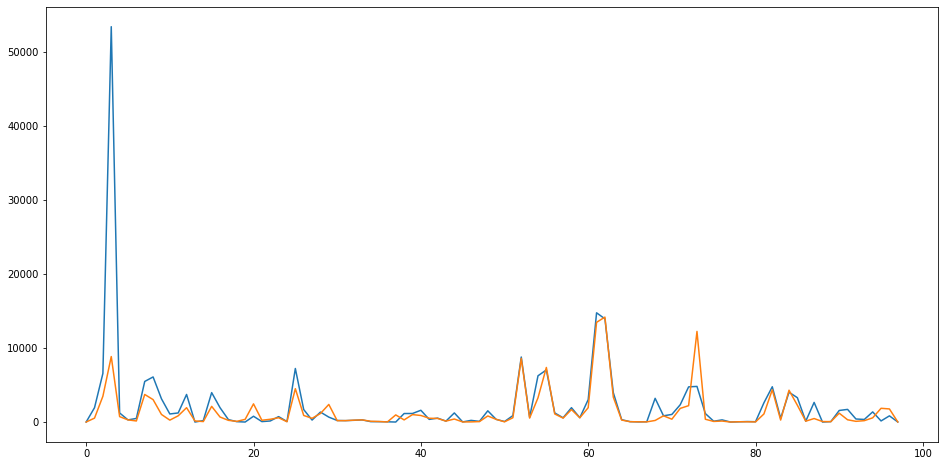

In [195]:
with open('CHL_KOR.txt', mode='r', encoding='utf-8') as f:
        # Replace en dash with hyphen
        rooku = f.read().replace('–', '-')

HS_CODE = r'(\d+\.\d+)'
HS_CODE_NC = r'(?:\d+\.\d+)'
HS_RANGE = r'({0}(?:\s?\-\s?{0})?)'.format(HS_CODE)
HS_RANGE_NC = r'{0}(?:\s?\-\s?{0})?'.format(HS_CODE_NC)

rooru = get_roo_rules(parse_roo(rooku), HS_maps[2017], complete=True)
def restriction_list(roo, HS_map, HS_exp_map):
    restrictions = {}
    pattern_range = re.compile(HS_RANGE)
    for section in roo:
        for chapter in roo[section]:
            for hs_code_range, rule in roo[section][chapter].items():
                # Get HS codes
                result = pattern_range.findall(hs_code_range)
                hs_codes = get_hs_codes(result[0][1], result[0][2], HS_map)
                
                # Classify the rule
                if patterns['CC'].search(rule):
                    for hs_code in hs_codes:
                        restrictions[hs_code] = HS_exp_map[hs_code[:2]]
                if patterns['CTH'].search(rule):
                    for hs_code in hs_codes:
                        restrictions[hs_code] = HS_exp_map[hs_code[:4]]
                if patterns['CTSH'].search(rule):
                    for hs_code in hs_codes:
                        restrictions[hs_code] = HS_exp_map[hs_code]
                if patterns['CTH_ECT'].search(rule):
                    unique_headings = list(set([hs_code[:4] for hs_code in hs_codes]))
                    all_restrictions = []
                    for heading in unique_headings:
                        all_restrictions.extend(HS_exp_map[heading])
                    for hs_code in hs_codes:
                        restrictions[hs_code] = all_restrictions
                if patterns['CTSH_ECT'].search(rule):
                    all_restrictions = []
                    for hs_code in hs_codes:
                        all_restrictions.extend(HS_exp_map[hs_code])
                    for hs_code in hs_codes:
                        restrictions[hs_code] = all_restrictions
    return restrictions

rooresu = restriction_list(parse_roo(rooku), HS_maps[2017], HS_exp_maps[2017])

charosu = Counter()   
chapters = HS_maps[2017].loc[HS_maps[2017]['Tier'] == 1, 'ProductCode']
for chapter in chapters:
    for hs_code in HS_exp_maps[2017][chapter]:
        charosu[chapter] += len(rooresu.get(hs_code, []))

puroto = [0 for i in range(98)]
for key, value in charosu.items():
    puroto[int(key)] = value

plt.figure(figsize=(16,8))
plt.plot(range(0, 98), puroto)
plt.plot(range(0, 98), pool['CHL_JPN'])

5613

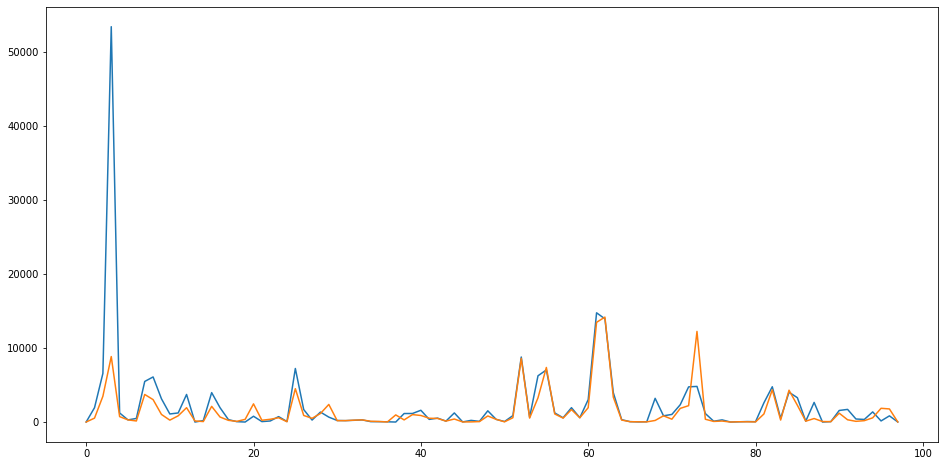

In [201]:
plt.figure(figsize=(16,8))
plt.plot(range(0, 98), puroto)
plt.plot(range(0, 98), pool['CHL_JPN'])
len(rooru)

# TO-DO: Normalize different versions of HS code

In [202]:
begin = Counter()
for hsc, rule in rooru.items():
    res = []
    for pattern in patterns.values():
        res.append(pattern.search(rule))
    if any(res):
        #print(pattern1.search(rule))
        continue
    begin[rule[:20]] += 1
    #print(rule)
#print('HERE', sum(begin.values()))
#print(begin, end='\n\n')
